In [ ]:
# for cloud use
!pip install pylatexenc qiskit==2.0.2 qiskit-aer

In [ ]:
from typing import List
from math import sqrt, acos, pi

from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.transpiler import generate_preset_pass_manager

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2

from utils import get_diagonal_attacks, get_pos_mapping, Mapping

In [2]:
def get_W(n:int) -> QuantumCircuit:
    """
    params:
        n : int - the board side

    Get the W state for n qubits.
    """

    qc = QuantumCircuit(n, name="W(%d)"%(n))

    get_theta = lambda i : 2*acos(1/sqrt(i))

    base_value = n
    for qubit in range(0, n-1):
        if qubit == 0:
            qc.ry(get_theta(base_value), 0)
        else:
            qc.cry(get_theta(base_value), qubit-1, qubit)
        base_value -= 1

    for qubit in range(n-1, 0, -1):
        qc.cx(qubit-1,qubit)

    qc.x(0)

    return qc


In [3]:
def get_W_with_zero_at(qubits:int, zero_pos:List[int]):
    qc = QuantumCircuit(qubits, name="W_zero(%d)"%(len(zero_pos)))

    W_pos = list(set(list(range(qubits)))-{*zero_pos})
    qc.compose(get_W(qubits-len(zero_pos)), W_pos, inplace=True)

    return qc.to_gate()

<IPython.core.display.Latex object>

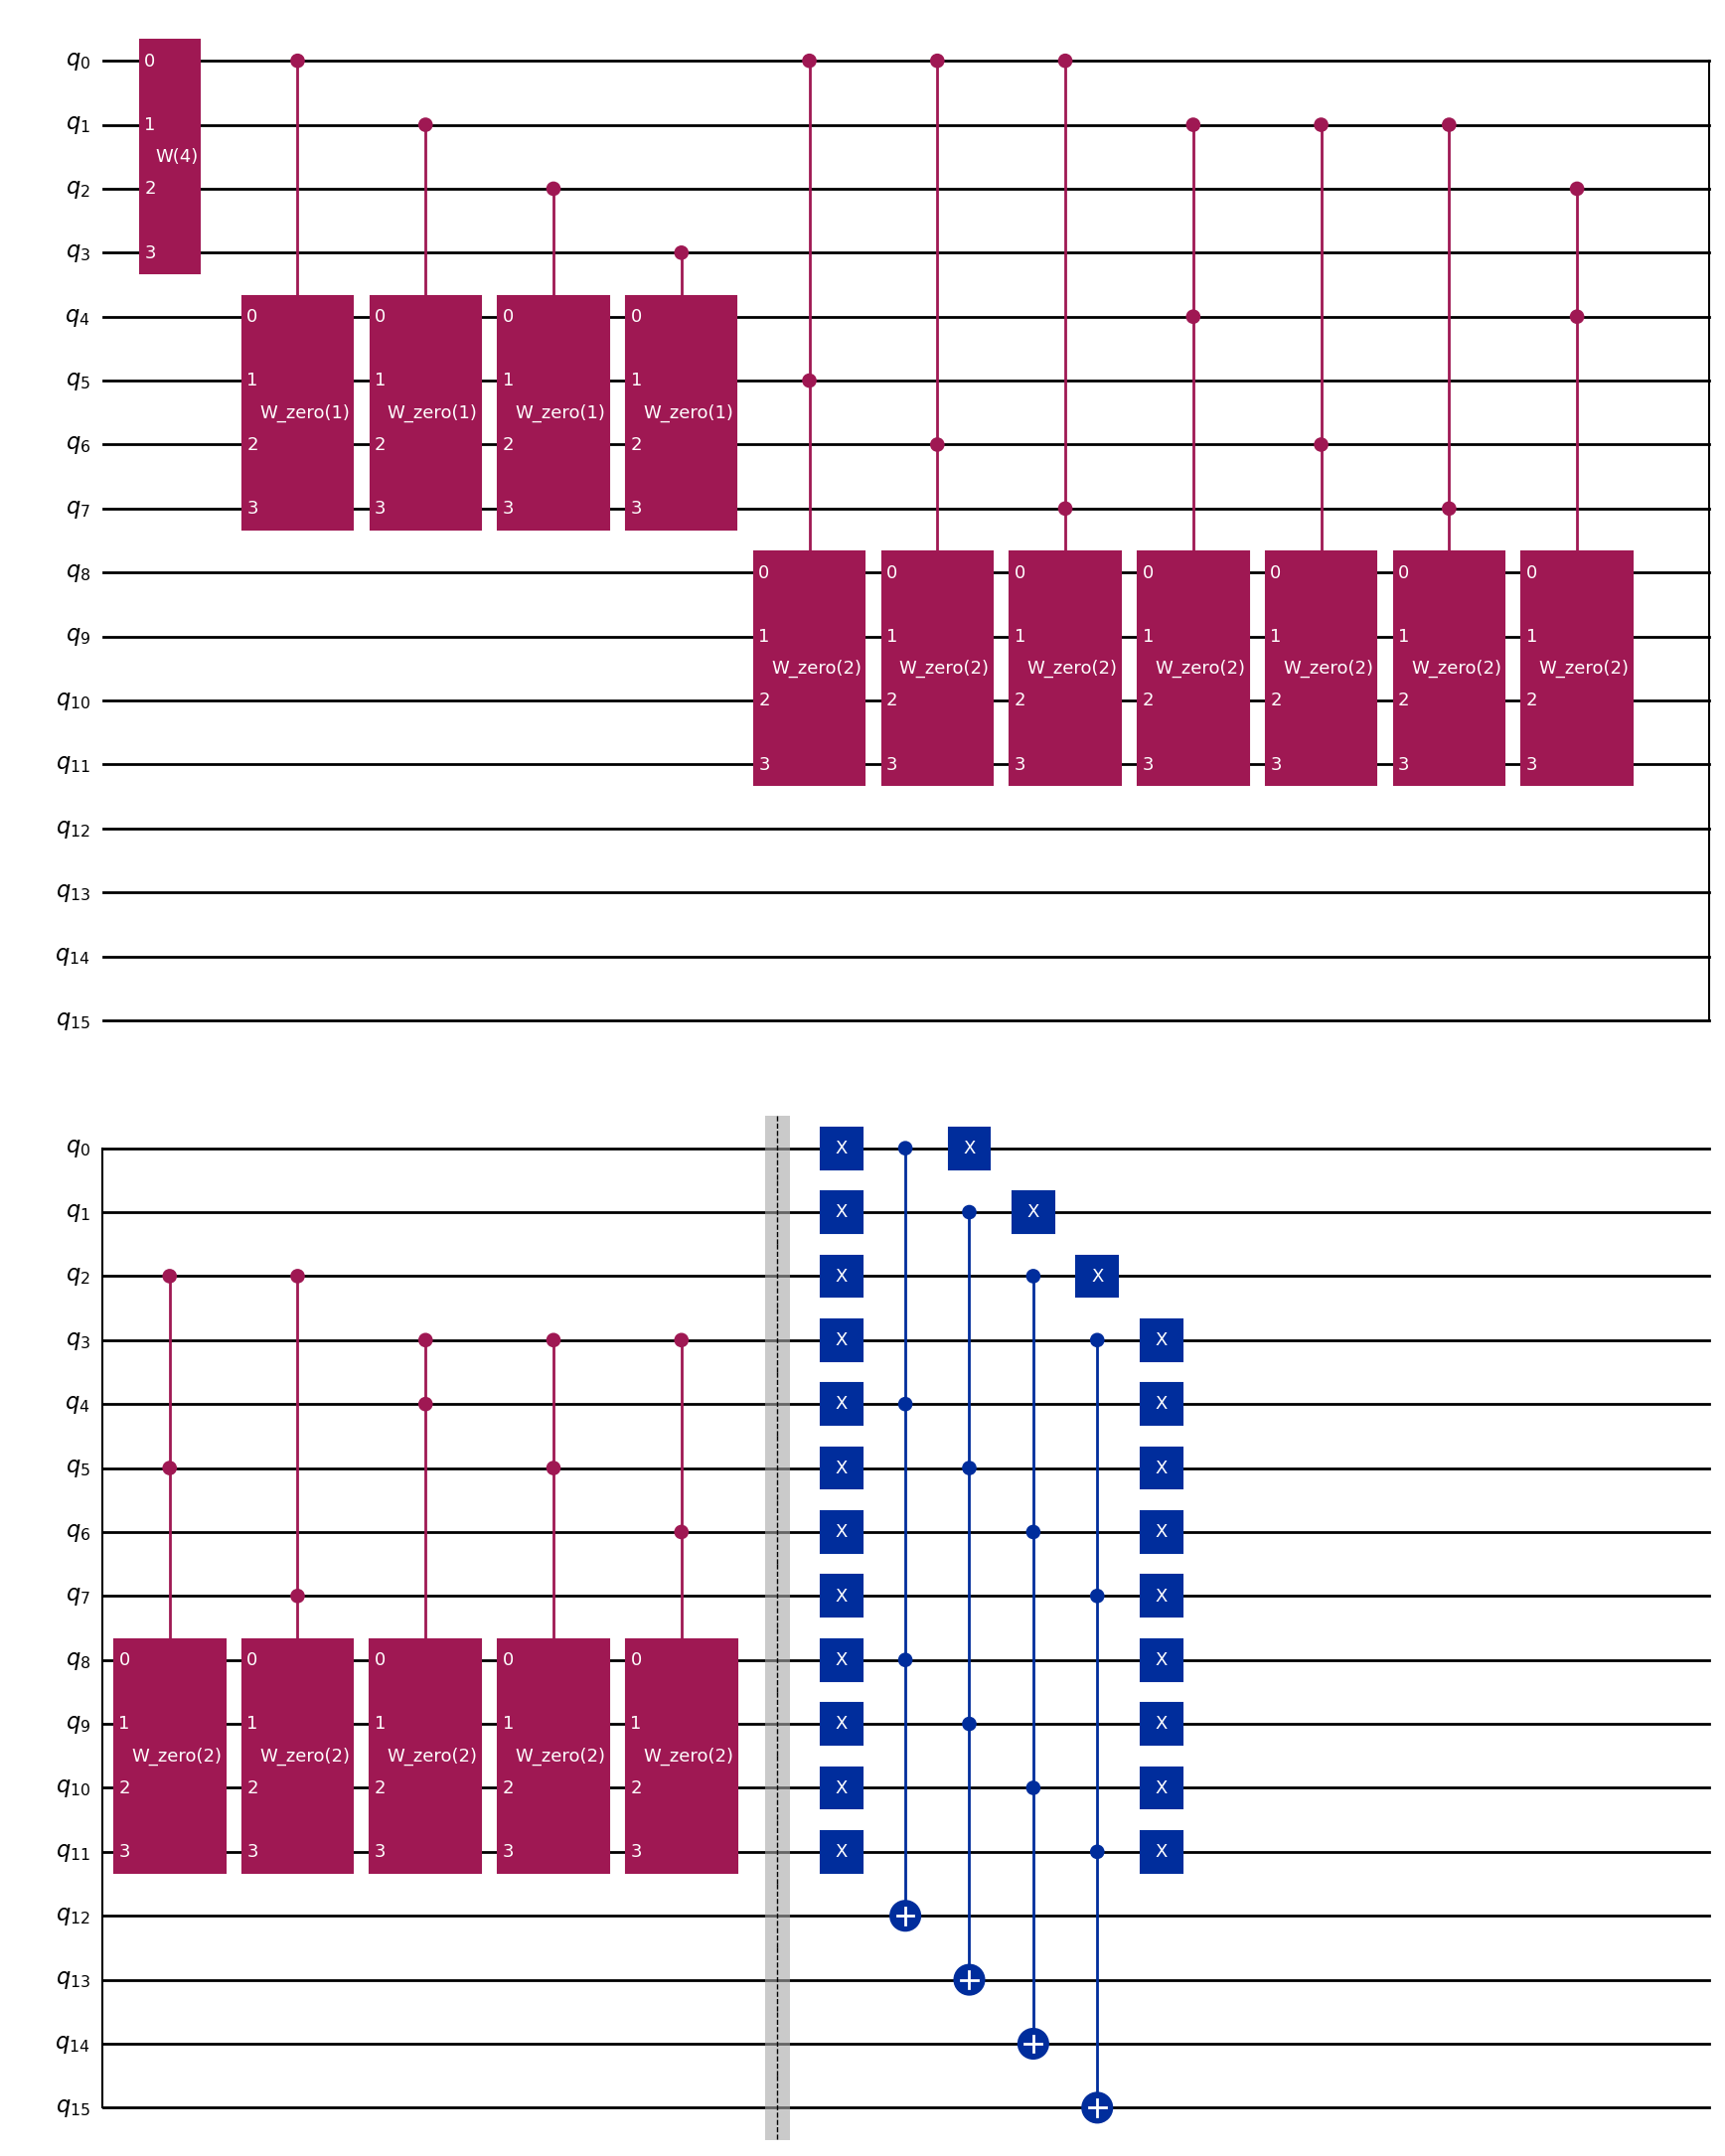

In [59]:
N = 4
total_qubits = N*N

state = QuantumCircuit(total_qubits, name="State")
state.append(get_W(N), list(range(N)))

state.append(get_W_with_zero_at(N,[0]).control(1), [0, *list(range(N,2*N))])
state.append(get_W_with_zero_at(N,[1]).control(1), [1, *list(range(N,2*N))])
state.append(get_W_with_zero_at(N,[2]).control(1), [2, *list(range(N,2*N))])
state.append(get_W_with_zero_at(N,[3]).control(1), [3, *list(range(N,2*N))])

state.append(get_W_with_zero_at(N,[0,1]).control(2), [0, 5, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[0,2]).control(2), [0, 6, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[0,3]).control(2), [0, 7, *list(range(2*N,3*N))])

state.append(get_W_with_zero_at(N,[1,0]).control(2), [1, 4, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[1,2]).control(2), [1, 6, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[1,3]).control(2), [1, 7, *list(range(2*N,3*N))])

state.append(get_W_with_zero_at(N,[2,0]).control(2), [2, 4, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[2,1]).control(2), [2, 5, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[2,3]).control(2), [2, 7, *list(range(2*N,3*N))])

state.append(get_W_with_zero_at(N,[3,0]).control(2), [3, 4, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[3,1]).control(2), [3, 5, *list(range(2*N,3*N))])
state.append(get_W_with_zero_at(N,[3,2]).control(2), [3, 6, *list(range(2*N,3*N))])

state.barrier()

state.x([0,4,8])
state.mcx([0,4,8],12)
state.x([0,4,8])

state.x([1,5,9])
state.mcx([1,5,9],13)
state.x([1,5,9])

state.x([2,6,10])
state.mcx([2,6,10],14)
state.x([2,6,10])

state.x([3,7,11])
state.mcx([3,7,11],15)
state.x([3,7,11])

display(Statevector(state).draw('latex'))
state.draw('mpl')

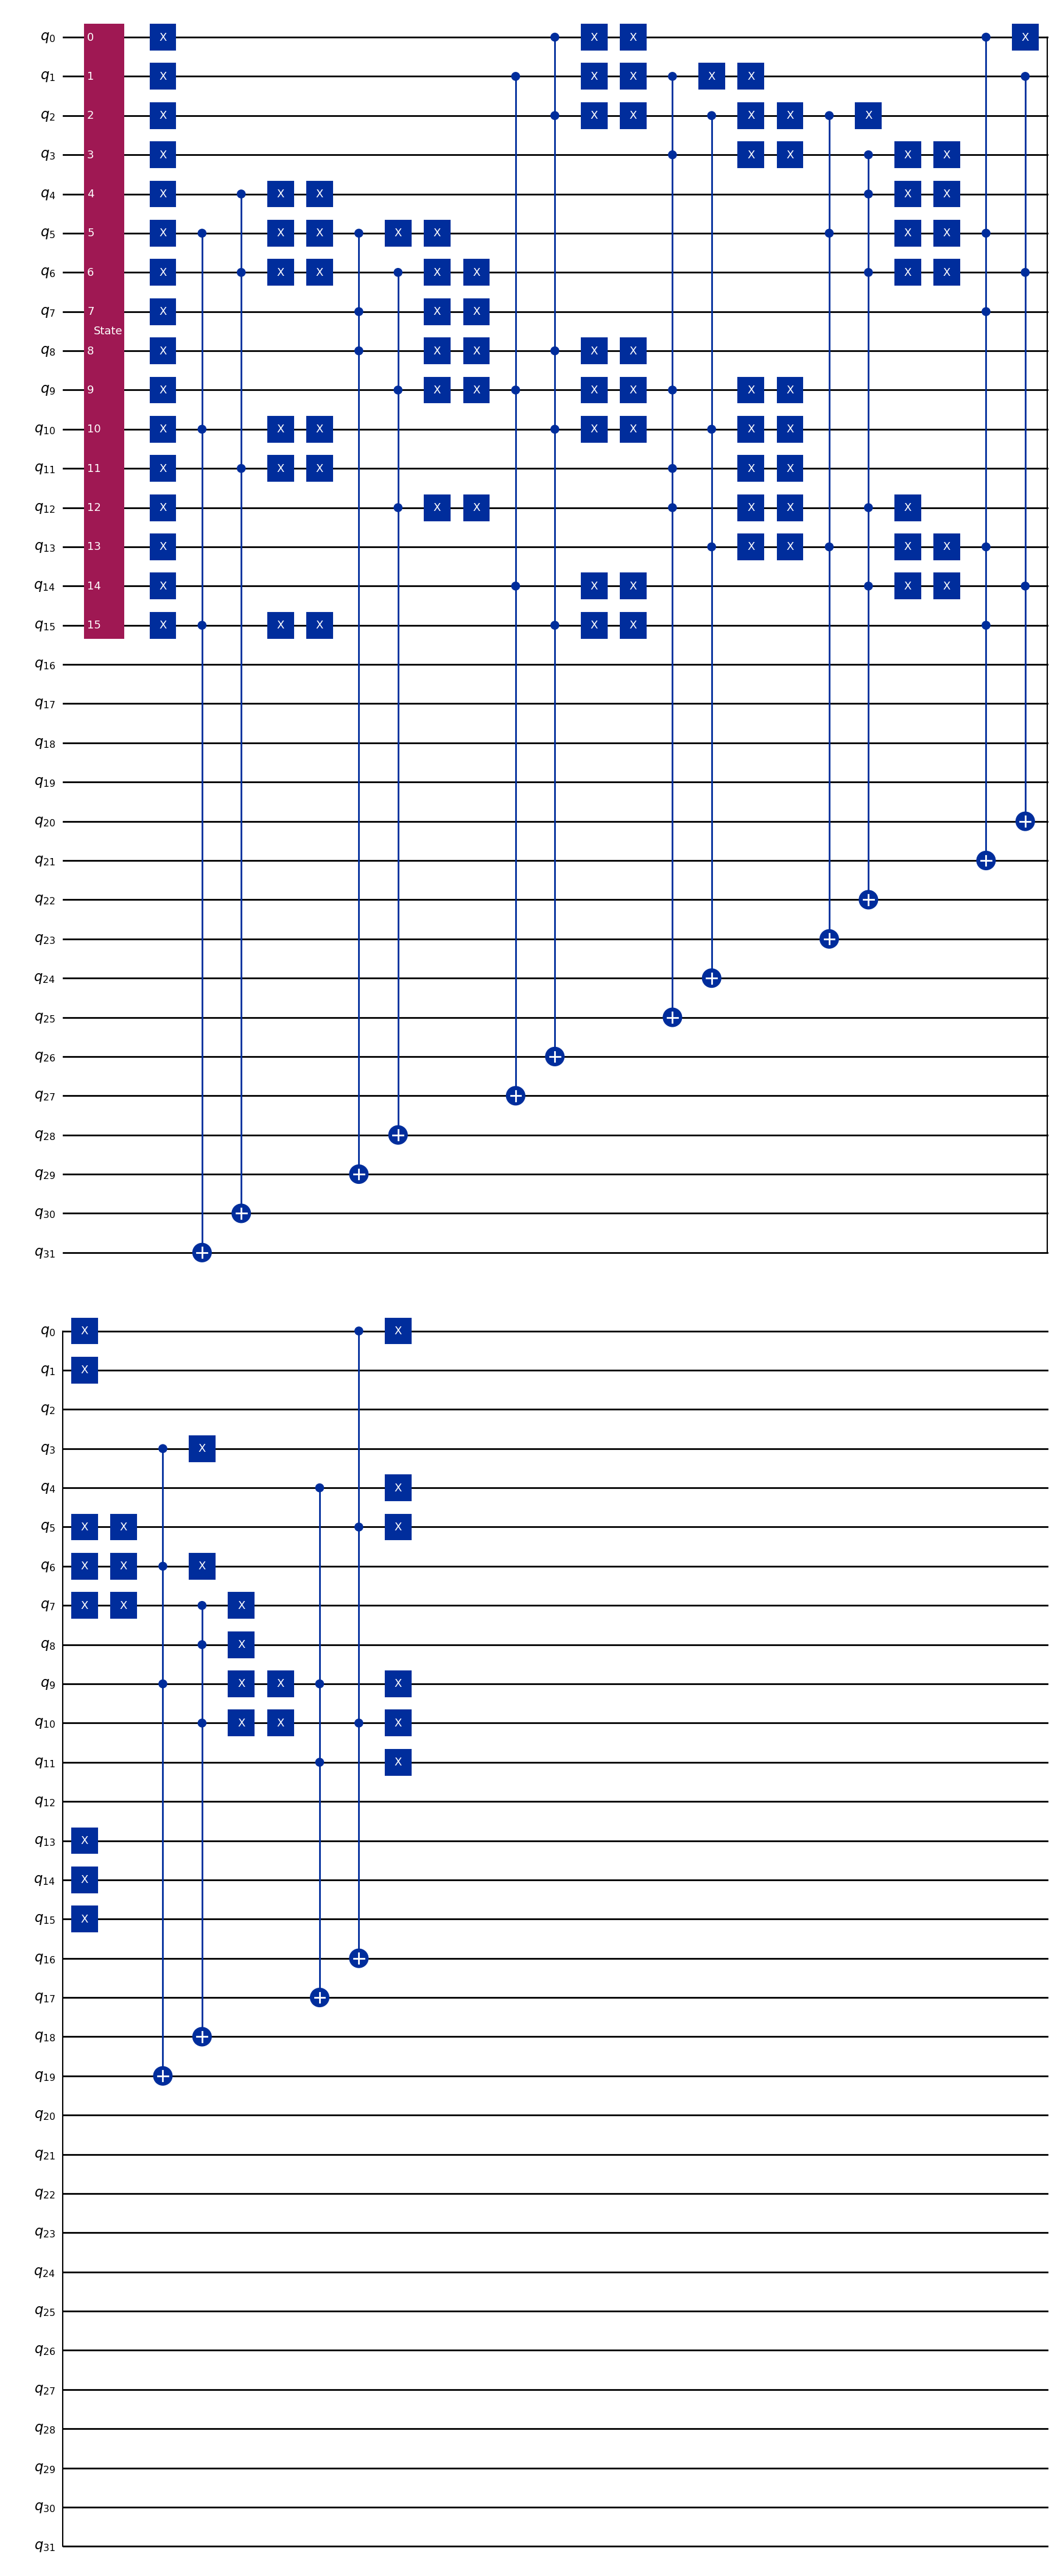

In [65]:
qc = QuantumCircuit(2*total_qubits)
qc.append(state, list(range(total_qubits)))

mapping = get_pos_mapping(N)

for pos, qubit in mapping.items():
    attacks = get_diagonal_attacks(pos,N)

    x_qubits = [mapping[attack] for attack in attacks]

    qc.x(x_qubits)
    qc.mcx(x_qubits, -(qubit+1))
    qc.x(x_qubits)
qc.draw('mpl')

In [64]:
sim = AerSimulator()
pm = generate_preset_pass_manager(optimization_level=0, backend=sim)
sampler = SamplerV2()

In [ ]:
isa_qc = pm.run(qc)
isa_qc.measure_all()
result = sampler.run([isa_qc], shots=1000).result()
plot_histogram(result[0].data.meas.get_counts())